In [1]:
import scipy as sp
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import pandas as pd
import seaborn as sns
import time
import statsmodels as sm
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import RandomizedSearchCV
import json
from matplotlib import pyplot as plt
from scipy.special import boxcox1p
from scipy.stats import skew
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lasso, LinearRegression, LassoCV, ElasticNetCV, ElasticNet, RidgeCV, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
import collections
import datetime
import json
import lightgbm as lgb
import matplotlib
import numpy as np
import pandas as pd
import re
import seaborn as sns
import time
import warnings
import xgboost as xgb
matplotlib.style.use('ggplot')
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
warnings.filterwarnings('ignore')


In [2]:
x_train = pd.read_csv('../data/X_train.csv')
x_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv')

In [ ]:
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

In [ ]:
def fe_step0 (actual):
    
    # https://www.mathworks.com/help/aeroblks/quaternionnorm.html
    # https://www.mathworks.com/help/aeroblks/quaternionmodulus.html
    # https://www.mathworks.com/help/aeroblks/quaternionnormalize.html
        
    actual['norm_quat'] = (actual['orientation_X']**2 + actual['orientation_Y']**2 + actual['orientation_Z']**2 + actual['orientation_W']**2)
    actual['mod_quat'] = (actual['norm_quat'])**0.5
    actual['norm_X'] = actual['orientation_X'] / actual['mod_quat']
    actual['norm_Y'] = actual['orientation_Y'] / actual['mod_quat']
    actual['norm_Z'] = actual['orientation_Z'] / actual['mod_quat']
    actual['norm_W'] = actual['orientation_W'] / actual['mod_quat']
    
    return actual

In [ ]:
def fe_step1 (actual):
    """Quaternions to Euler Angles"""
    
    x, y, z, w = actual['norm_X'].tolist(), actual['norm_Y'].tolist(), actual['norm_Z'].tolist(), actual['norm_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    return actual

In [3]:
def feat_eng(data):
    
    df = pd.DataFrame()
    data['totl_anglr_vel'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 + \
                              data['angular_velocity_Z']**2)** 0.5
    data['totl_linr_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 + \
                             data['linear_acceleration_Z']**2)**0.5
    data['totl_xyz'] = (data['orientation_X']**2 + data['orientation_Y']**2 + data['orientation_Z']**2)**0.5
    data['acc_vs_vel'] = data['totl_linr_acc'] / data['totl_anglr_vel']
    
    def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))
    
    for col in data.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        df[col + '_mean'] = data.groupby(['series_id'])[col].mean()
        df[col + '_median'] = data.groupby(['series_id'])[col].median()
        df[col + '_max'] = data.groupby(['series_id'])[col].max()
        df[col + '_min'] = data.groupby(['series_id'])[col].min()
        df[col + '_std'] = data.groupby(['series_id'])[col].std()
        df[col + '_range'] = df[col + '_max'] - df[col + '_min']
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + '_mean_abs_chg'] = data.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        df[col + '_mean_change_of_abs_change'] = data.groupby('series_id')[col].apply(mean_change_of_abs_change)
        df[col + '_abs_max'] = data.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        df[col + '_abs_min'] = data.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        df[col + '_abs_avg'] = data.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(x)))
    return df

In [4]:
x_train = feat_eng(x_train)
# test = feat_eng(test)

In [5]:
x_test = feat_eng(x_test)

In [6]:
x_train.fillna(0,inplace=True)
x_test.fillna(0,inplace=True)
x_train.replace(-np.inf,0,inplace=True)
x_train.replace(np.inf,0,inplace=True)
x_test.replace(-np.inf,0,inplace=True)
x_test.replace(np.inf,0,inplace=True)

Fold: 0 score: 0.922077922077922


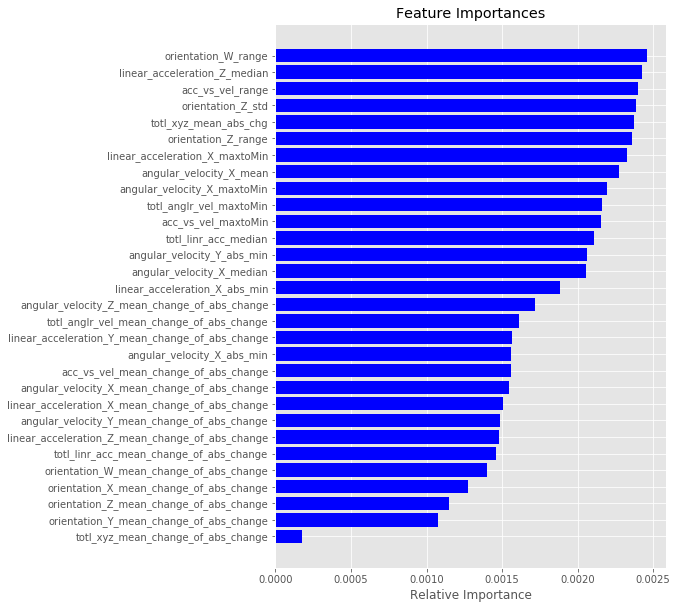

Fold: 1 score: 0.859375
Fold: 2 score: 0.8798955613577023
Fold: 3 score: 0.8900523560209425
Fold: 4 score: 0.89501312335958
Fold: 5 score: 0.8661417322834646
Fold: 6 score: 0.8556430446194225
Fold: 7 score: 0.8548812664907651
Fold: 8 score: 0.8756613756613757
Fold: 9 score: 0.8962765957446809


In [9]:
le = LabelEncoder()
y_train['surface'] = le.fit_transform(y_train['surface'])
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=59)


predicted = np.zeros((x_test.shape[0],9))
measured= np.zeros((x_train.shape[0]))
score = 0

for times, (trn_idx, val_idx) in enumerate(folds.split(x_train.values,y_train['surface'].values)):
    model = RandomForestClassifier(n_estimators=500, n_jobs = -1)
    model.fit(x_train.iloc[trn_idx],y_train['surface'][trn_idx])
    measured[val_idx] = model.predict(x_train.iloc[val_idx])
    predicted += model.predict_proba(x_test)/folds.n_splits
    score += model.score(x_train.iloc[val_idx],y_train['surface'][val_idx])
    print("Fold: {} score: {}".format(times,model.score(x_train.iloc[val_idx],y_train['surface'][val_idx])))

    importances = model.feature_importances_
    indices = np.argsort(importances)
    features = x_train.columns
    
    if model.score(x_train.iloc[val_idx],y_train['surface'][val_idx]) > 0.95000:
        hm = 30
        plt.figure(figsize=(7, 10))
        plt.title('Feature Importances')
        plt.barh(range(len(indices[:hm])), importances[indices][:hm], color='b', align='center')
        plt.yticks(range(len(indices[:hm])), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()

    gc.collect()

In [16]:
def MSE_score(estimator):
    # index = self.insolation_info.insolation_datetime
    estimator.fit(x_train, y_train)
    # predicted = estimator.predict(self.X_test)
    # test_index = index[index < self.test_split]
    # pd.concat([test_index, predicted], axis=1)
    return mean_squared_error(self.y_validation, estimator.predict(self.X_validation)) ** 0.5

run_best_models()

NameError: name 'MSE_score' is not defined

In [9]:
scaler_type = 'Robust'

In [10]:
if scaler_type =='Robust':
    scaler = RobustScaler().fit(x_train)
else:
    scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [13]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self

    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        # kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        kfold = TimeSeriesSplit(n_splits=self.n_folds)
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in list(kfold.split(X, y)):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    #Do the predictions of all base models on the test data and use the averaged predictions as
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)


In [14]:
def get_best_params(estimator, param_grid, epochs = 2):
    start = time.time()
    current_optimum = {key:[value[0],] for key, value in param_grid.items()}
    current_evaluated = {key:False for key in param_grid.keys()}
    cross_validation = list(TimeSeriesSplit(n_splits=5).split(x_train))
    for i in range(epochs):
        for key, value in param_grid.items():
            current_optimum[key] = value
            grid_search = GridSearchCV(estimator, param_grid=current_optimum, cv = cross_validation)
            grid_search.fit(x_train, y_train)
            current_optimum[key] = [grid_search.best_params_[key],]
            grid_scores.append(grid_search.grid_scores_)
            current_evaluated[key] = True
            # print(current_evaluated)
            print(current_optimum)
            with open('current_optimum.json', 'a+') as fp:
                json.dump(current_optimum, fp)
            with open('other_parameters.txt', 'a+') as fh:
                fh.write("key : "+key+"\n"+"time : "+str(time.time()-start))
            # print(estimator, key)
            print(time.time()-start)
    print(current_optimum)
    return grid_search, current_optimum

def run_best_models():
    result = []
    start = time.time()
    cross_validation = list(TimeSeriesSplit(n_splits=5).split(x_train))
    #LR
    lr = LinearRegression(n_jobs = -1)
    lr = lr.fit(x_train, y_train)
    result.append({'model':'linear_regression','MSE_score':MSE_score(lr)})
    print('-'*20, 'lr', '-'*20)
    end = time.time()
    print(end-start)
    #Lasso
    lasso = LassoCV(eps=0.001, n_alphas=100, alphas=[0.001, 0.01,0.1, 1.0], fit_intercept=True,
                    normalize=False, precompute='auto', max_iter=1000, tol=0.0001, copy_X=True,
                    cv=cross_validation, verbose=False, n_jobs=-1, positive=False, random_state=None,
                    selection='random')
    lasso = lasso.fit(x_train, y_train)
    result.append({'model':'lasso','MSE_score':MSE_score(lasso)})
    print('-'*20, 'lasso', '-'*20)
    end = time.time()
    print(end-start)
    #Elastic Net
    # alphas = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0]
    # l1_ratios = [0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 1.0]
    # fit_intercepts = [True, False]
    # parameter_grid = {'alpha':alphas,  'l1_ratio':l1_ratios, 'fit_intercept': fit_intercepts}
    enet = ElasticNetCV(normalize=False, selection='cyclic')
    # gs_enet, current_opti_enet = get_best_params(enet, parameter_grid)
    gs_enet = enet.fit(x_train, y_train)
    result.append({'model':'enet','MSE_score':MSE_score(gs_enet)})
    print('-'*20, 'enet', '-'*20)
    end = time.time()
    print(end-start)
#         # Light GBM
    light = lgb.LGBMRegressor(random_state = 5, bagging_freq = 1, bagging_fraction = 0.5, feature_fraction = 0.5)
    boosting_types = ['dart', 'gbdt', 'rf']
    learning_rates = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0]
    n_estimators = [100, 500, 1000]
    max_depth = [-1, 2, 5]
    reg_alphas = [0.01, 0.05, 0.1, 0.5, 1.0]
    reg_lambdas = [0.01, 0.05, 0.1, 0.5, 1.0]
    parameter_grid = {'boosting_type': boosting_types, 'learning_rate':learning_rates,
                      'n_estimators':n_estimators, 'reg_alpha': reg_alphas, 'reg_lambda':reg_lambdas,'max_depth':max_depth}
    gs_light, current_opti_light = get_best_params(light, parameter_grid)
    result.append({'model':'gs_light','MSE_score':MSE_score(gs_light)})
    print('-'*20, 'lightgbm', '-'*20)
    end = time.time()
    print(end-start)

    #RandomForest
    forest = RandomForestRegressor(min_samples_leaf=30, random_state = 23)
    n_estimators = [100, 500, 1000]
    max_features = ['sqrt', 'log2', None]
    parameter_grid = {'n_estimators':n_estimators, 'max_features':max_features}
    gs_forest, current_opti_forest = get_best_params(forest, parameter_grid)
    result.append({'model':'gs_forest','MSE_score':MSE_score(gs_forest)})
    print('-'*20, 'forest', '-'*20)
    end = time.time()
    print(end-start)

    #XGBoost
    model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, min_child_weight=1.7817,
                 subsample=0.5213, silent=1, random_state =7, nthread = -1)
    learning_rates = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0]
    n_estimators = [100, 500, 1000]
    max_depth = [1, 2, 5]
    reg_alphas = [0.01, 0.05, 0.1, 0.5, 1.0]
    reg_lambdas = [0.01, 0.05, 0.1, 0.5, 1.0]
    gammas = [0.01, 0.05, 0.1, 0.5, 1.0]
    parameter_grid = {'gamma': gammas, 'learning_rate':learning_rates,
                      'n_estimators':n_estimators, 'reg_alpha': reg_alphas,
                      'reg_lambda':reg_lambdas,'max_depth':max_depth}
    gs_xgb, current_opti_xgb = get_best_params(model_xgb, parameter_grid)
    result.append({'model':'gs_xgb','MSE_score':MSE_score(gs_xgb)})
    print('-'*20, 'Xgb', '-'*20)
    end = time.time()
    print(end-start)
    #GradientBoosting
    GBoost = GradientBoostingRegressor(min_samples_leaf=15, min_samples_split=10,
        random_state =5)
    pipeline = Pipeline([
        ('preproc', FeatureUnion([
            ('pca', PCA()),
            ('svd', TruncatedSVD()),
            ('skb', SelectKBest(f_regression))
            ])),
        ('model', GradientBoostingRegressor(
            min_samples_leaf=15,
            min_samples_split=10,
            random_state =5))
        ])
    parameter_grid = {'preproc__pca__n_components':[2, 5, 10, 20],
                      'preproc__svd__n_components':[2, 5, 10, 20],
                      'preproc__skb__k':[5, 10, 20, 40, 50, 60],
                      'model__n_estimators':[200, 500, 1000],
                      'model__max_depth':[1, 2, 3, 4, 5]

                     }
    get_best_params(estimator=pipeline, param_grid=parameter_grid, epochs=3)
    n_estimators = [100, 500, 1000]
    learning_rates = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0]
    max_depth = [1, 2, 5]
    alphas = [0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99]
    max_features = ['sqrt', 'log2', None]
    criteria = ['mse', 'mae', 'friedman_mse']
    losses = ['huber', 'ls', 'lad', 'quantile']
    parameter_grid = {'criterion': criteria, 'loss':losses,'n_estimators':n_estimators,
                      'max_features':max_features, 'max_depth':max_depth,
                      'learning_rate':learning_rates, 'alpha':alphas}
    gs_GBoost, current_opti_GBoost = get_best_params(GBoost, parameter_grid)
    result.append({'model':'gs_GBoost','MSE_score':MSE_score(gs_GBoost)})
    print('-'*20, 'gbm', '-'*20)
    end = time.time()
    print(end-start)

    #averaged models
    averaged_models = AveragingModels(models = (gs_GBoost, gs_light, gs_forest, lasso))
    result.append({'model':'avg_models','MSE_score':MSE_score(averaged_models)})
    print('-'*20, 'avg_models', '-'*20)
    end = time.time()
    print(end-start)
    #stacked models
    stacked_averaged_models = StackingAveragedModels(base_models =
        (gs_GBoost, gs_light, gs_forest), meta_model = lasso)
    result.append({'model':'stacked','MSE_score':fpc.MSE_score(stacked_averaged_models)})
    print('-'*20, 'stacked', '-'*20)
    end = time.time()
    print(end-start)
    return result
